In [3]:
from spacepy import pycdf
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [20]:
limit = 360 # latch to this many CDF files for testing. Each CDF is a day of champ data.
champ_root_dir = "/Users/patrick/Dev/perceptive_techeval/data/champ-2002-2007/"

df_arr = []
processed = 0
for root, dirs, files in os.walk(os.path.abspath(champ_root_dir)):
    for file in [os.path.join(root, f) for f in files[0:limit] if f.endswith(".cdf")]:
        cdf = pycdf.CDF(file)
        alt = cdf["altitude"][:]/1000.0
        lat = cdf["latitude"][:]
        lon = cdf["longitude"][:]
        lst = cdf["local_solar_time"][:]
        valid = cdf["validity_flag"][:]
        density = cdf["density"][:]
        density_orbitmean = cdf["density_orbitmean"][:]
        time = cdf["time"][:]

        unix_timestamps = [dt.timestamp() for dt in time]
        density[density > 1e30] = np.nan # 1e30 is a stand-in for nan for these data. 
        delta_density = cdf["density"][:] - cdf["density_orbitmean"][:]

        df_arr.append(pl.DataFrame({"timestamp": unix_timestamps, "altitude":alt, "latitude":lat, "longitude":lon, "local_solar_time":lst, "validity_flag":valid, "density_orbitmean":density_orbitmean,"density":density, "delta_density":delta_density}))
        
        processed += 1 
        if processed >= limit:
            break
        
df = pl.concat(df_arr)

In [21]:
df

timestamp,altitude,latitude,longitude,local_solar_time,validity_flag,density_orbitmean,density,delta_density
f64,f64,f64,f64,f64,i8,f64,f64,f64
1.1955e9,363.735018,-63.969321,123.038927,8.448712,0,1.3856e-12,1.1696e-12,-2.1600e-13
1.1955e9,363.523534,-63.320587,123.155861,8.459285,0,1.3861e-12,1.1738e-12,-2.1226e-13
1.1955e9,363.308092,-62.671597,123.265817,8.469393,0,1.3865e-12,1.1843e-12,-2.0221e-13
1.1955e9,363.088786,-62.022361,123.36928,8.479068,0,1.3870e-12,1.1965e-12,-1.9048e-13
1.1955e9,362.865709,-61.372889,123.466692,8.488339,0,1.3875e-12,1.2013e-12,-1.8617e-13
…,…,…,…,…,…,…,…,…
1.0163e9,444.277574,-52.482581,102.607316,6.683964,0,4.8336e-12,2.3879e-12,-2.4457e-12
1.0163e9,443.899562,-51.843208,102.646719,6.689369,0,4.8337e-12,2.3979e-12,-2.4358e-12
1.0163e9,443.517267,-51.203656,102.683861,6.694624,0,4.8338e-12,2.4104e-12,-2.4234e-12


In [22]:
# try something really simple first.

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
random_seed = 123

mask = (~df["density"].is_null()) & (df["validity_flag"] == 0)
X = df.filter(mask).select(["altitude", "latitude", "longitude", "local_solar_time"]).to_numpy()
y = df.filter(mask)["density"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=random_seed) # train, test, validation splits
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=random_seed) 

pipeline = make_pipeline(StandardScaler(),
                         SGDRegressor(max_iter=1000, tol=1e-3, random_state=random_seed))
param_grid = {
    "sgdregressor__alpha": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=random_seed), scoring="neg_mean_squared_error", verbose=2, n_jobs=4)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_["sgdregressor__alpha"]

print("best alpha: " + str(best_alpha))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
best alpha: 0.01


Mean Squared Error (MSE): 5.118262564688006e-25
Mean Absolute Error (MAE): 5.436594627779041e-13
R² Score: 0.14287338020329732


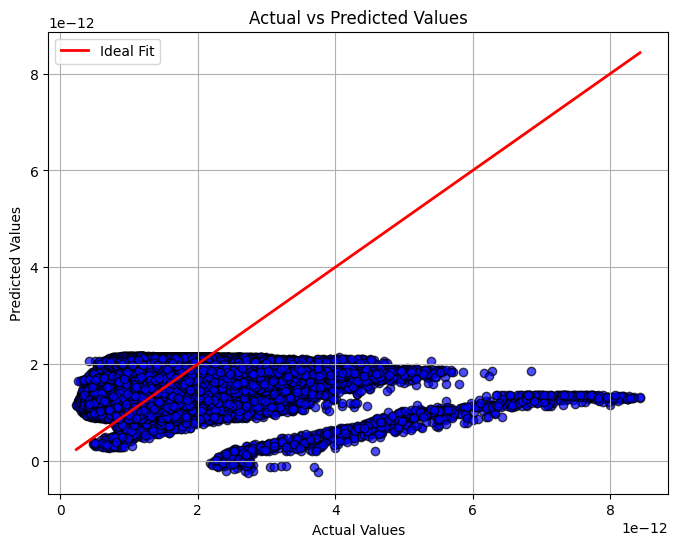

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

Mean Squared Error (MSE): 5.118349764761376e-25
Mean Absolute Error (MAE): 5.436216147428857e-13
R² Score: 0.14285877729787977


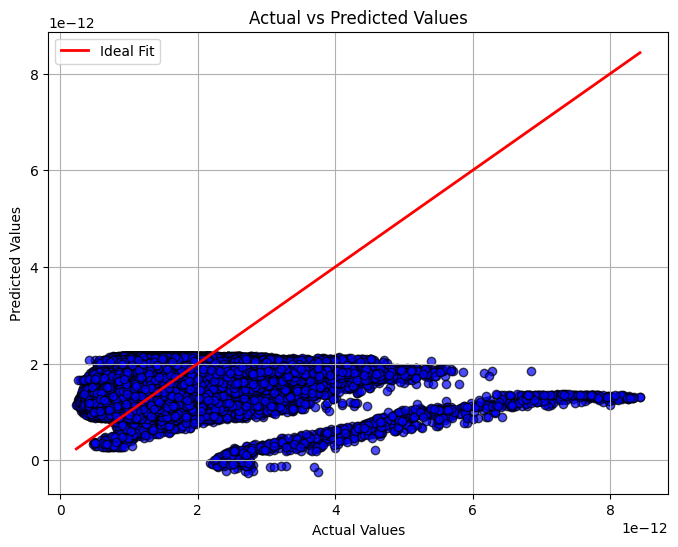

In [24]:
best_model = pipeline.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
random_seed = 123

mask = (~df["density"].is_null()) & (df["validity_flag"] == 0)
X = df.filter(mask).select(["altitude", "latitude", "longitude", "local_solar_time"]).to_numpy()
y = df.filter(mask)["density"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=random_seed) # train, test, validation splits
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=random_seed) 

pipeline = make_pipeline(StandardScaler(),
                         XGBRegressor(random_state=random_seed))

Mean Squared Error (MSE): 5.971440395374407e-25
Mean Absolute Error (MAE): 5.970897506763448e-13
R² Score: -3.508361776871638e-06


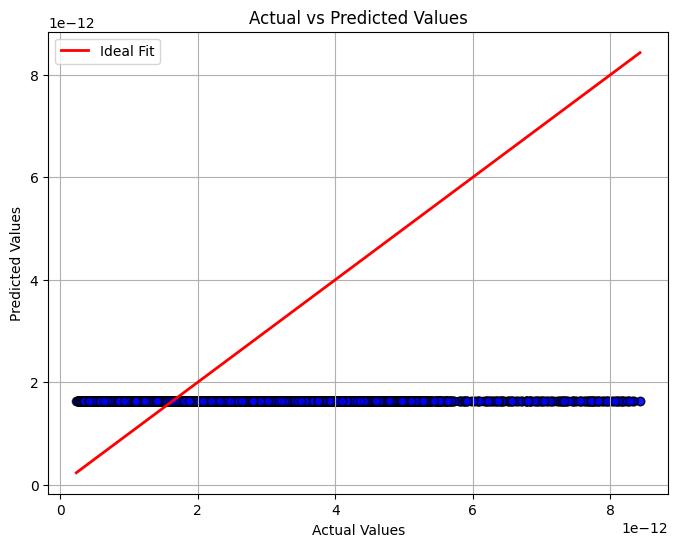

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_model = pipeline.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, label='Ideal Fit')
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

(array([1.16420e+04, 1.12996e+05, 1.97252e+05, 2.63558e+05, 3.39586e+05,
        3.72030e+05, 3.51309e+05, 3.00315e+05, 2.43989e+05, 2.03057e+05,
        1.68684e+05, 1.37578e+05, 1.10863e+05, 8.78720e+04, 6.65120e+04,
        4.72040e+04, 3.36720e+04, 2.59040e+04, 1.75970e+04, 1.27890e+04,
        8.73500e+03, 6.31200e+03, 4.12600e+03, 3.04200e+03, 1.81300e+03,
        1.29600e+03, 1.00600e+03, 6.87000e+02, 4.97000e+02, 2.94000e+02,
        2.21000e+02, 2.17000e+02, 2.64000e+02, 2.33000e+02, 1.98000e+02,
        2.26000e+02, 1.77000e+02, 1.80000e+02, 2.36000e+02, 2.05000e+02,
        2.20000e+02, 1.95000e+02, 1.34000e+02, 6.70000e+01, 1.20000e+01,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

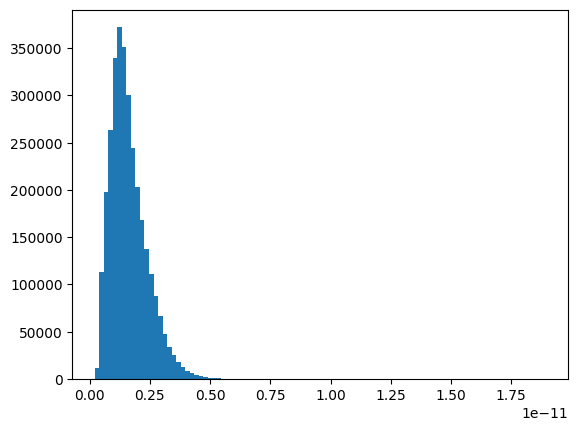

In [28]:
plt.hist(df["density"],bins=100)

In [ ]:
plt.hist(df["l"])